In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import tensorflow as tf
import time
import scipy
import os

from final.model import Model
from final.helpers import Helpers
from final.datahandler import DataHandler
from final.dihedralcalculator import DihedralCalculator

import txt_data_utils.data_transformer as dt

In [107]:
### DATA AND QUEUE CONFIGURATION ###
data_path = "/home/mikey/Data/ProteinNet/"
validation_casps = ['casp11']
training_casps = ['casp11']
training_percentages = [30, 50, 70, 90, 95, 100]
max_len = None # max len of the protein taken into account

num_epochs = 500
batch_size= 32
capacity=1000

### MODEL CONFIGURATION ###
include_evo = True

model_type = 'cnn_big'
dropout_rate = 0.2

mode_a = 'alphabet' # regression or alphabet
mode_b = 'vectors' # angles or vectors

prediction_mode = mode_a + '_' + mode_b
n_clusters = 50 # only needed when prediction mode == alphabet

angularization_mode = None
regularize_vectors = None
if prediction_mode == 'regression_angles':
    angularization_mode = 'cos' # 'cos' or 'tanh', only matters in the regression_angles mode

if prediction_mode == 'regression_vectors':
    regularize_vectors = True # True or False, only matters in the regression_vectors mode

loss_mode = 'mae'
n_angles = 2

In [108]:
tf.reset_default_graph()

data_mode = 'testing' # validation or testing

data_handler = DataHandler(data_path=data_path,
                           casps=validation_casps,
                           num_epochs=1,
                           mode='testing')

ids, one_hot_primary, evolutionary, _, tertiary, ter_mask, pri_length, keep =\
    data_handler.generate_batches(batch_size = 1,
                                  capacity = 1000,
                                  max_protein_len = max_len)

dihedral_calculator = DihedralCalculator()
true_dihedrals = dihedral_calculator.dihedral_pipeline(tertiary, protein_length = tf.shape(one_hot_primary)[1])

with tf.Session() as sess:
    sess.run(tf.group(tf.global_variables_initializer(), tf.local_variables_initializer()))
    
    coord = tf.train.Coordinator()  
    threads = tf.train.start_queue_runners(coord=coord, sess=sess)

    try:
        ids_v, ohp_v, evo_v, tert_v, ter_mask_v, dih_v = [], [], [], [], [], []
        while not coord.should_stop(): 
            ids_, one_hot_primary_, evolutionary_, tertiary_, ter_mask_, pri_length_, keep_, true_dihedrals_ = sess.run([ids, one_hot_primary, evolutionary, tertiary, 
                                                                                                        ter_mask, pri_length, keep, true_dihedrals])
        
            ids_v.append(np.squeeze(ids_))
            ohp_v.append(np.squeeze(one_hot_primary_))
            evo_v.append(np.squeeze(evolutionary_))
            tert_v.append(np.squeeze(tertiary_))
            ter_mask_v.append(np.squeeze(ter_mask_))
            dih_v.append(np.squeeze(true_dihedrals_))
        
    except tf.errors.OutOfRangeError:
        print('Done')
    finally:
        # When done, ask the threads to stop.
        coord.request_stop()

        # Wait for threads to finish.
        coord.join(threads)
        sess.close()
        
prim_v, evo_v, dih_v, mask_v = dt.limit_length_and_pad(ohp_v, evo_v, dih_v, ter_mask_v, max_length=None)
x_valid, y_valid = np.concatenate([prim_v, evo_v], axis=2), dih_v
x_valid.shape, y_valid.shape

['/home/mikey/Data/ProteinNet/casp11/testing/*']
Training samples available 81
Done
padded


((81, 669, 41), (81, 669, 3))

In [ ]:
tf.reset_default_graph()

# define the training data paths and how many epochs they should be queued for
# by instantiating the DataHandler object that takes care of parsing
data_handler = DataHandler(data_path=data_path,
                           casps=training_casps,
                           percentages=training_percentages, 
                           num_epochs=num_epochs,
                           mode='training')

# use DataHandler to generate batches of specific size 
# and optional limit on protein length
# secondary structure is missing from the ProteinNet, thus the underscore
ids, one_hot_primary, evolutionary, _, tertiary, ter_mask, pri_length, keep =\
    data_handler.generate_batches(batch_size = batch_size,
                                  capacity = capacity,
                                  max_protein_len = max_len)

# convert euclidean coordinates to dihedral angles
dihedral_calculator = DihedralCalculator()
true_dihedrals = dihedral_calculator.dihedral_pipeline(tertiary, protein_length = tf.shape(one_hot_primary)[1])
true_dihedrals = true_dihedrals[:,:,:n_angles]

# set up placeholders with batch_size=None to be able to feed them with validation data
# they fall onto default coming from the queue if nothing is fed through feed_dict
true_dihedrals = tf.placeholder_with_default(true_dihedrals, shape=(None, None, n_angles))
true_vectors = Helpers.ang_to_vec_tf(true_dihedrals)
one_hot_primary = tf.placeholder_with_default(one_hot_primary, shape=(None, None, 20))
evolutionary = tf.placeholder_with_default(evolutionary, shape=(None, None, 21))
ter_mask = tf.placeholder_with_default(ter_mask, shape=(None, None))

# build a model and get predicted output
model = Model(n_angles=n_angles, 
              n_clusters=n_clusters,
              output_mask=ter_mask,
              model_type=model_type, 
              prediction_mode=prediction_mode,
              dropout_rate=dropout_rate,
              ang_mode=angularization_mode,
              regularize_vectors=regularize_vectors,
              loss_mode=loss_mode
            )

if include_evo:
    input_data = tf.concat([one_hot_primary, evolutionary], axis=2)
else:
    input_data = one_hot_primary

rad_pred_masked, vec_pred_masked = model.build_model(input_data)

true_dihedrals_masked, true_vectors_masked = model.mask_other([true_dihedrals, true_vectors])

loss, loss_vec = model.calculate_loss(true_dihedrals_masked, rad_pred_masked,
                                      true_vectors_masked, vec_pred_masked)

mae_vec = Helpers.loss360(true_dihedrals_masked, rad_pred_masked)

pcc = Helpers.pearson_tf(rad_pred_masked, true_dihedrals_masked)

# learning rate placeholder for adaptive learning rate
learning_rate = tf.placeholder(tf.float32, name='learning_rate')

# choose an optimizer to minimize the loss
global_step = tf.Variable(0, name='global_step', trainable=False)
train_op = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss, global_step=global_step)

init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
try:
    n_parameters = np.sum([np.prod(v.get_shape().as_list()) for v in tf.trainable_variables()])
    print("Parameters:", n_parameters)
except:
    print("Couldn't calculate the number of parameters")

['/home/mikey/Data/ProteinNet/casp11/training/30/*', '/home/mikey/Data/ProteinNet/casp11/training/50/*', '/home/mikey/Data/ProteinNet/casp11/training/70/*', '/home/mikey/Data/ProteinNet/casp11/training/90/*', '/home/mikey/Data/ProteinNet/casp11/training/95/*', '/home/mikey/Data/ProteinNet/casp11/training/100/*']


Training loop

In [ ]:
learning_rate_decay = 0.99
steps_to_print_after = 200
init_learning_rate = 0.001
load_checkpoint = False
save_checkpoint = True

def try_create_dir(path):
    try:
        os.mkdir(path)
        print("Created directory: " + path)
    except:
        print("Didn't create the directory: " + path)
        pass

try_create_dir('./checkpoints')
try_create_dir('./checkpoints/' + prediction_mode)
try_create_dir('./checkpoints/' + prediction_mode + '/tmp')

checkpoint_path = "./checkpoints/" + prediction_mode + "/tmp/"+loss_mode+"_"+str(n_angles)+"_model.ckpt"
print("checkpoint path:", checkpoint_path)

if 'lstm' in model_type:
    init_learning_rate = 0.001
    steps_to_print_after = 200
    
saver = tf.train.Saver()
with tf.Session() as sess:
    # important to call both of these, because 
    # otherwise can't specify num_epochs in string_input_producer
    sess.run(init)
    
    if load_checkpoint:
        saver.restore(sess, checkpoint_path)
    
    coord = tf.train.Coordinator()  
    threads = tf.train.start_queue_runners(coord=coord, sess=sess)

    try:
        step = 1
        
        losses = []
        loss_vecs = []
        mae_vecs = []
        
        train_losses = []
        train_maes = []
        val_maes = []
        pccs = []
        
        while not coord.should_stop():        
                
            _, true_dihedrals_, rad_pred_masked_, loss_, loss_vec_, mae_vec_ = sess.run([train_op, true_dihedrals, 
                                                                    rad_pred_masked, loss, loss_vec, mae_vec], 
                                                                    feed_dict={learning_rate: init_learning_rate})

            losses.append(loss_)
            loss_vecs.append(loss_vec_)
            mae_vecs.append(mae_vec_)
            
            if step % steps_to_print_after == 0:
                avg_loss, avg_loss_vec =  np.mean(losses), np.mean(np.array(loss_vecs), axis=0)
                train_losses.append(avg_loss_vec)
                train_maes.append(np.mean(np.array(mae_vecs), axis=0))
                print("Train loss:", avg_loss, avg_loss_vec)

                losses = []
                loss_vecs = []
                mae_vecs = []
                
                (true_dihedrals_masked_v, rad_pred_masked_v, 
                 loss_, loss_vec_, mae_vec_v) = sess.run([true_dihedrals_masked, rad_pred_masked, 
                                                   loss, loss_vec, mae_vec], 
                                                   feed_dict={
                                                           one_hot_primary: prim_v,
                                                           evolutionary: evo_v,
                                                           true_dihedrals: dih_v[:,:,:n_angles],
                                                           ter_mask: mask_v
                                                          })
                pcc = Helpers.pearson_numpy(np.squeeze(true_dihedrals_masked_v)[:,:n_angles], 
                                                               np.array(rad_pred_masked_v))
                print("Validation loss:", loss_, loss_vec_)
                print("Validation PCC:", pcc)
                print("Validation MAE:", mae_vec_v)
                val_maes.append(mae_vec_v)
                pccs.append(pcc)
            
            if step * batch_size > data_handler.training_samples:
                step = 0
                init_learning_rate = init_learning_rate * learning_rate_decay
                print("EPOCH. New learning rate:", init_learning_rate)
                
                if save_checkpoint:
                    save_path = saver.save(sess, checkpoint_path)
                    print("Model saved in path: %s" % save_path)
                
            step += 1

    except tf.errors.OutOfRangeError:
        print('Done training for %d epochs, %d steps.' % (num_epochs, step))
    finally:
        
        # When done, ask the threads to stop.
        coord.request_stop()

        # Wait for threads to finish.
        coord.join(threads)
        sess.close()

In [100]:
train_maes = np.array(train_maes)
val_maes = np.array(val_maes)
pccs = np.array(pccs)

Plot the avg losses over time

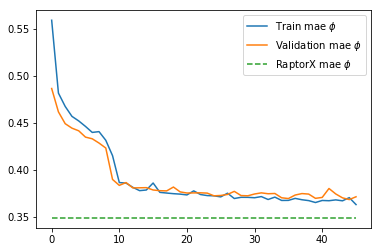

In [101]:
plt.plot(train_maes[:,0], label='Train mae $\phi$')
plt.plot(val_maes[:,0], label='Validation mae $\phi$')
plt.plot(np.ones_like(val_maes[:,0]) * np.deg2rad(20), '--', label='RaptorX mae $\phi$')
plt.legend()

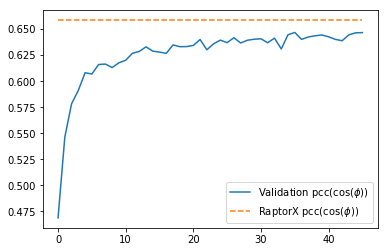

In [102]:
plt.plot(pccs[:,0], label='Validation pcc(cos($\phi$))')
plt.plot(np.ones_like(pccs[:,0]) * 0.6585, '--', label='RaptorX pcc(cos($\phi$))')
plt.legend()

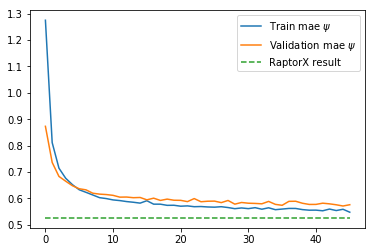

In [104]:
plt.plot(train_maes[:,1], label='Train mae $\psi$')
plt.plot(val_maes[:,1], label='Validation mae $\psi$')
plt.plot(np.ones_like(val_maes[:,0]) * np.deg2rad(30.14), '--', label='RaptorX result')
plt.legend()

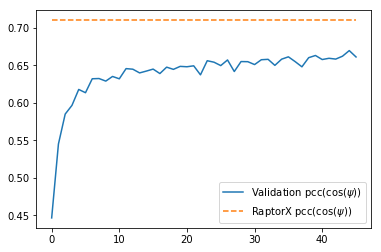

In [105]:
plt.plot(pccs[:,1], label='Validation pcc(cos($\psi$))')
plt.plot(np.ones_like(pccs[:,0]) * 0.7103, '--', label='RaptorX pcc(cos($\psi$))')
plt.legend()

In [106]:
# plt.plot(train_maes[:,2], label='Train mae $\omega$')
# plt.plot(val_maes[:,2], label='Validation mae $\omega$')
# # plt.plot(np.ones_like(val_maes[:,0]) * np.deg2rad(30.14), '--', label='RaptorX result')
# plt.legend()

IndexError: index 2 is out of bounds for axis 1 with size 2

Get just the dihedral angles to see if they resemble how a ramachadran plot should look like

In [56]:
protein_n = 12

def get_predictions(protein_n):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())
        saver.restore(sess, checkpoint_path)

        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord, sess=sess)

        true, pred, mae_ = sess.run([true_dihedrals_masked, rad_pred_masked, mae_vec])

        (true, pred, mae_) = sess.run([true_dihedrals_masked, rad_pred_masked, mae_vec], 
                                                       feed_dict={
                                                               one_hot_primary: np.expand_dims(prim_v[protein_n], 0),
                                                               evolutionary: np.expand_dims(evo_v[protein_n], 0),
                                                               true_dihedrals: np.expand_dims(dih_v[protein_n,:,:n_angles], 0),
                                                               ter_mask: np.expand_dims(mask_v[protein_n],0)
                                                              })

        coord.request_stop()
    return true, pred

INFO:tensorflow:Restoring parameters from ./checkpoints/regression_vectors/tmp/mae_3_model.ckpt


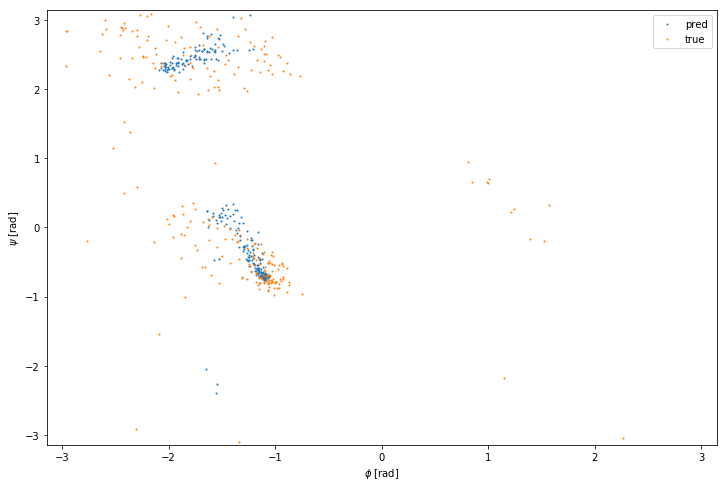

In [73]:
true, pred = get_predictions(18)

plt.figure(figsize=(12,8))

phi, psi, omega = np.split(pred, 3, -1)
plt.scatter(phi[:], psi[:], s=1, label='pred')

phi, psi, omega = np.split(true, 3, -1)
plt.scatter(phi[:], psi[:], s=1, label='true')

plt.xlim((-np.pi, np.pi))
plt.ylim((-np.pi, np.pi))
plt.xlabel('$\phi$ [rad]')
plt.ylabel('$\psi$ [rad]')
plt.legend(loc=1)

In [ ]:
plt.hist(omega[protein_n], bins=100)

In [ ]:
#                 # access trainable variables to see if they're training
#                 variables_names = [v.name for v in tf.trainable_variables()]
#                 values = sess.run(variables_names)
#                 for k, v in zip(variables_names, values):
#                     print("Variable: ", k)
#                     print("Shape: ", v.shape)
#                     print(v)

In [ ]:
# def _coordinates(config, dihedrals):
#     """ Converts dihedrals into full 3D structures. """

#     # converts dihedrals to points ready for reconstruction.
#     points = dihedral_to_point(dihedrals) # [NUM_STEPS x NUM_DIHEDRALS, BATCH_SIZE, NUM_DIMENSIONS]
             
#     # converts points to final 3D coordinates.
#     coordinates = point_to_coordinate(points, num_fragments=config['num_reconstruction_fragments'], 
#                                               parallel_iterations=config['num_reconstruction_parallel_iters']) 
#                   # [NUM_STEPS x NUM_DIHEDRALS, BATCH_SIZE, NUM_DIMENSIONS]

#     return coordinates

# def _drmsds(config, coordinates, targets, weights):
#     """ Computes reduced weighted dRMSD loss (as specified by weights) 
#         between predicted tertiary structures and targets. """
                  
#     # compute per structure dRMSDs
#     drmsds = drmsd(coordinates, targets, weights, name='drmsds') # [BATCH_SIZE]

#     # add to relevant collections for summaries, etc.
#     if config['log_model_summaries']: tf.add_to_collection(config['name'] + '_drmsdss', drmsds)

#     return drmsds